In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *

In [3]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

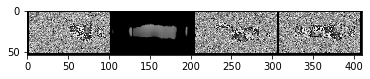

In [4]:
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from PIL import Image

#Probablemente no haga falta normalizar porque ya estan normalizadas
class DatasetPersonalizado(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, index):
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])
        image = Image.open(img_loc)
        image = self.transform(image)
        if self.total_imgs[index][0].isupper():
            label = 1
        else: label = 0
        #label = self.total_imgs[index].isupper()
        return (image, label)

transform = transforms.ToTensor()

dataset = DatasetPersonalizado('./DatasetSoldadurasJuntas/' , transform)
#Numero de imagenes con las que vamos a entrenar


train_set, test_set = torch.utils.data.random_split(dataset, [1300, 202],
        generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2)   

testloader = torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2)  


#Ver como seleccionar las imagenes que vamos a mostrar adecuadamente
img_list = []

for i in range(4):
    img_list.append(train_set.__getitem__(i)[0])

#print(img_list)
show(make_grid(img_list))


#img_list[0].size()

In [5]:
#Definimos la red neuronal
import torch.nn as nn
import torch.nn.functional as F

class Red(nn.Module):
    def __init__(self):
        super(Red, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 6)
        self.fc1 = nn.Linear(16 * 8 * 21 , 120)
        self.fc2 = nn.Linear(120, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(x.size(0), 16 * 8 * 21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


red = Red()




In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision.transforms as transforms

In [51]:
import skimage.util
import numpy as np
import cv2

#from skimage import data , io

#print(scikit.image.__version__)

class AddGaussianNoise:
    """Clase para añadir ruido gausiano"""

    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

image = Image.open('./DatasetSoldaduras/NFD1/Pieza_39_Soldadura_77.png')

#image2 = cv2.imread('./DatasetSoldaduras/NFD1/Pieza_39_Soldadura_77.png' , cv2.IMREAD_GRAYSCALE)
image2 = Image.open('./DatasetSoldaduras/NFD1/Pieza_39_Soldadura_77.png')

image.show()

image = np.asarray(image)

print(np.count_nonzero(image))

print(image)

image = skimage.util.random_noise(image, mode='gaussian' , seed=42)

ruido = transforms.Compose([
    transforms.ToTensor(),
    #AddGaussianNoise(0.4,0.14),
    AddGaussianNoise(0,0.01),
    transforms.ToPILImage()
])

image2 = ruido(image)

image2.show()

print(np.count_nonzero(image))


image = Image.fromarray((image * 255).astype(np.uint8))

image.save('imagenRuido.png')

image.show()


7115
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
22663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([4, 3, 3])
torch.Size([4, 1, 3, 3])
torch.Size([4, 1, 50, 100])


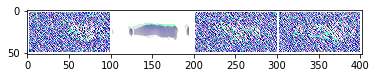

In [88]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

left_edge = tensor([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]).float()



edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
print(edge_kernels.shape)
img_list = torch.stack(img_list)
edge_kernels = edge_kernels.unsqueeze(1)
print(edge_kernels.size())
print(img_list.size())

features = F.conv2d(img_list , edge_kernels)
show(make_grid(features))


In [142]:
#Definimos una funcion de perdida.
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(red.parameters() , lr=0.01, momentum=0.8 )

In [143]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = red(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.647
[2,   200] loss: 0.334
[3,   200] loss: 0.331
[4,   200] loss: 0.338
[5,   200] loss: 0.328
[6,   200] loss: 0.329
[7,   200] loss: 0.329
[8,   200] loss: 0.330
[9,   200] loss: 0.331
[10,   200] loss: 0.325
Finished Training


In [144]:
PATH = './soldaduras.pth'
torch.save(red.state_dict(), PATH)

GroundTruth:  tensor(1) tensor(1) tensor(0) tensor(1) tensor(1)


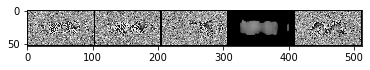

In [145]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
show(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(5)))

In [146]:
red = Red()
red.load_state_dict(torch.load(PATH))

outputs = red(images)

predicted = []

"""
for i in range(4):
    print(outputs[i])
    predicted.append(torch.)
"""
print(outputs)
predicted = torch.max(outputs,1)
print(predicted)
values = predicted[1]

#print('Predicted: ', ' '.join('%5s' % predicted[1]
#                              for j in range(2)))

print('Predicted: ', ' '.join('%5s' % values[j]
                                 for j in range(5)))

tensor([[ 0.1691, -0.1485],
        [ 0.1691, -0.1485],
        [ 0.1691, -0.1485],
        [-6.1215,  7.1063],
        [ 0.1691, -0.1485]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([0.1691, 0.1691, 0.1691, 7.1063, 0.1691], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 1, 0]))
Predicted:  tensor(0) tensor(0) tensor(0) tensor(1) tensor(0)


In [147]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = red(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print('Total: %d , Correct: %d'  % (total , correct))

Accuracy of the network on the 10000 test images: 75 %
Total: 202 , Correct: 152
